In [ ]:
%cd /content/

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir data

In [ ]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/MEDAI_MAR/abdomen/Abdomen.zip -d /content/data
!unzip /content/drive/MyDrive/Colab\ Notebooks/MEDAI_MAR/abdomen/data.zip

Archive:  /content/drive/MyDrive/Colab Notebooks/MEDAI_MAR/abdomen/data.zip
   creating: content/data/
   creating: content/data/Abdomen/
   creating: content/data/Abdomen/RawData/
   creating: content/data/Abdomen/RawData/Training/
   creating: content/data/Abdomen/RawData/Training/label/
  inflating: content/data/Abdomen/RawData/Training/label/label0027.nii.gz  
  inflating: content/data/Abdomen/RawData/Training/label/label0004.nii.gz  
  inflating: content/data/Abdomen/RawData/Training/label/label0023.nii.gz  
  inflating: content/data/Abdomen/RawData/Training/label/label0021.nii.gz  
  inflating: content/data/Abdomen/RawData/Training/label/label0001.nii.gz  
  inflating: content/data/Abdomen/RawData/Training/label/label0032.nii.gz  
  inflating: content/data/Abdomen/RawData/Training/label/label0031.nii.gz  
  inflating: content/data/Abdomen/RawData/Training/label/label0030.nii.gz  
  inflating: content/data/Abdomen/RawData/Training/label/label0002.nii.gz  
  inflating: content/data

In [ ]:
# !rm -r '/content/data/Abdomen/RegData'

In [ ]:
!pip install SimpleITK
# !pip install torchview

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.1 MB/s eta 0:00:00


In [ ]:

import os
import cv2
import torch
import warnings
import ipywidgets
import numpy as np
import pandas as pd
from torch import nn
import nibabel as nib
from glob import glob
from PIL import Image
from torchsummary import summary
import torch.optim as optim
# from unet3d import UNet3d
from IPython import display
import matplotlib.pyplot as plt
from skimage.util import montage
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from natsort import natsorted
# from keras.preprocessing.image import ImageDataGenerator
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.tensorboard import SummaryWriter
import torch.optim.lr_scheduler as lr_scheduler
import SimpleITK as sitk
import logging
import torch.backends.cudnn as cudnn
import sys
cfg_path= '/content/content/data/Abdomen/RawData/Training'

<ipython-input-7-8ca5826f2bdd>:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:

img_list= glob(cfg_path+"/img"+"/img*.gz", recursive= True)

In [ ]:
natsorted(img_list)

['/content/content/data/Abdomen/RawData/Training/img/img0001.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0002.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0003.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0004.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0005.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0006.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0007.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0008.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0009.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0010.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0021.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0022.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0023.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0024.nii.gz',
 '/content/content/d

In [ ]:

mask_list= glob(cfg_path+"/label"+"/label*.gz", recursive= True)

In [ ]:
natsorted(mask_list)

['/content/content/data/Abdomen/RawData/Training/label/label0001.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0002.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0003.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0004.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0005.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0006.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0007.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0008.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0009.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0010.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0021.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0022.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/label/label0023.nii.gz',
 '/content/content/data/Abdomen/RawDat

In [ ]:
# import matplotlib
# import numpy as np
# import matplotlib.pyplot as plt

# def cmap_map(function, cmap):
#     """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
#     This routine will break any discontinuous points in a colormap.
#     """
#     cdict = cmap._segmentdata
#     step_dict = {}
#     # Firt get the list of points where the segments start or end
#     for key in ('red', 'green', 'blue'):
#         step_dict[key] = list(map(lambda x: x[0], cdict[key]))
#     step_list = sum(step_dict.values(), [])
#     step_list = np.array(list(set(step_list)))
#     # Then compute the LUT, and apply the function to the LUT
#     reduced_cmap = lambda step : np.array(cmap(step)[0:3])
#     old_LUT = np.array(list(map(reduced_cmap, step_list)))
#     new_LUT = np.array(list(map(function, old_LUT)))
#     # Now try to make a minimal segment definition of the new LUT
#     cdict = {}
#     for i, key in enumerate(['red','green','blue']):
#         this_cdict = {}
#         for j, step in enumerate(step_list):
#             if step in step_dict[key]:
#                 this_cdict[step] = new_LUT[j, i]
#             elif new_LUT[j,i] != old_LUT[j, i]:
#                 this_cdict[step] = new_LUT[j, i]
#         colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
#         colorvector.sort()
#         cdict[key] = colorvector

#     return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [ ]:
# light_jet = cmap_map(lambda x: x/2 + 0.5, matplotlib.cm.jet)

In [ ]:
# import math

# import numpy as np
# from matplotlib.colors import ListedColormap
# from matplotlib.cm import hsv


# def generate_colormap(number_of_distinct_colors: int = 80):
#     if number_of_distinct_colors == 0:
#         number_of_distinct_colors = 80

#     number_of_shades = 7
#     number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

#     # Create an array with uniformly drawn floats taken from <0, 1) partition
#     linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

#     # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
#     #     but each saw tooth is slightly higher than the one before
#     # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
#     arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

#     # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
#     arr_by_shade_columns = arr_by_shade_rows.T

#     # Keep number of saw teeth for later
#     number_of_partitions = arr_by_shade_columns.shape[0]

#     # Flatten the above matrix - join each row into single array
#     nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

#     # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
#     initial_cm = hsv(nums_distributed_like_rising_saw)

#     lower_partitions_half = number_of_partitions // 2
#     upper_partitions_half = number_of_partitions - lower_partitions_half

#     # Modify lower half in such way that colours towards beginning of partition are darker
#     # First colours are affected more, colours closer to the middle are affected less
#     lower_half = lower_partitions_half * number_of_shades
#     for i in range(3):
#         initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

#     # Modify second half in such way that colours towards end of partition are less intense and brighter
#     # Colours closer to the middle are affected less, colours closer to the end are affected more
#     for i in range(3):
#         for j in range(upper_partitions_half):
#             modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
#             modifier = j * modifier / upper_partitions_half
#             initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

#     return ListedColormap(initial_cm)

In [ ]:

import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import numpy as np
from scipy import ndimage
from scipy.ndimage import zoom

In [ ]:
def rgb_white2alpha(rgb, ensure_increasing=False, ensure_linear=False, lsq_linear=False):
    """
    Convert a set of RGB colors to RGBA with maximum transparency.

    The transparency is maximised for each color individually, assuming
    that the background is white.

    Parameters
    ----------
    rgb : array_like shaped (N, 3)
        Original colors.
    ensure_increasing : bool, default=False
        Ensure that alpha values increase monotonically.
    ensure_linear : bool, default=False
        Ensure alpha values increase linear from initial to final value.
    lsq_linear : bool, default=False
        Use least-squares linear fit for alpha.

    Returns
    -------
    rgba : numpy.ndarray shaped (N, 4)
        Colors with maximum possible transparency, assuming a white
        background.
    """
    # The most transparent alpha we can use is given by the min of RGB
    # Convert it from saturation to opacity
    alpha = 1. - np.min(rgb, axis=1)
    if lsq_linear:
        # Make a least squares fit for alpha
        indices = np.arange(len(alpha))
        A = np.stack([indices, np.ones_like(indices)], axis=-1)
        m, c = np.linalg.lstsq(A, alpha, rcond=None)[0]
        # Use our least squares fit to generate a linear alpha
        alpha = c + m * indices
        alpha = np.clip(alpha, 0, 1)
    elif ensure_linear:
        # Use a linearly increasing/decreasing alpha from start to finish
        alpha = np.linspace(alpha[0], alpha[-1], rgb.shape[0])
    elif ensure_increasing:
        # Let's also ensure the alpha value is monotonically increasing
        a_max = alpha[0]
        for i, a in enumerate(alpha):
            alpha[i] = a_max = np.maximum(a, a_max)
    alpha = np.expand_dims(alpha, -1)
    # Rescale colors to discount the white that will show through from transparency
    rgb = (rgb + alpha - 1)
    rgb = np.divide(rgb, alpha, out=np.zeros_like(rgb), where=(alpha > 0))
    rgb = np.clip(rgb, 0, 1)
    # Concatenate our alpha channel
    rgba = np.concatenate((rgb, alpha), axis=1)
    return rgba

def cmap_white2alpha(name, ensure_increasing=False, ensure_linear=False, lsq_linear=False, register=True):
    """
    Add as much transparency as possible to a colormap, assuming white background.

    Parameters
    ----------
    name : str
        Name of builtin (or registered) colormap.
    ensure_increasing : bool, default=False
        Ensure that alpha values are strictly increasing.
    ensure_linear : bool, default=False
        Ensure alpha values increase linear from initial to final value.
    lsq_linear : bool, default=False
        Use least-squares linear fit for alpha.
    register : bool, default=True
        Whether to register the new colormap.

    Returns
    -------
    cmap : matplotlib.colors.ListedColormap
        Colormap with alpha set as low as possible.
    """
    # Fetch the cmap callable
    cmap = plt.get_cmap(name)
    # Get the colors out from the colormap LUT
    rgb = cmap(np.arange(cmap.N))[:, :3]  # N-by-3
    # Convert white to alpha
    rgba = rgb_white2alpha(
        rgb,
        ensure_increasing=ensure_increasing,
        ensure_linear=ensure_linear,
        lsq_linear=lsq_linear,
    )
    # Create a new Colormap object
    new_name = name + "_white2alpha"
    cmap_alpha = matplotlib.colors.ListedColormap(rgba, name=new_name)
    if register:
        matplotlib.cm.register_cmap(name=new_name, cmap=cmap_alpha)
    return cmap_alpha

In [ ]:
cmap_w2a = cmap_white2alpha("jet")

<ipython-input-16-caa95e978a07>:90: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap(name=new_name, cmap=cmap_alpha)


In [ ]:
N = 16
M = 7

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import colorsys
from scipy import ndimage
from scipy.ndimage import zoom
from torch.utils.data import Dataset
from torchvision import transforms


def man_cmap(cmap, value=1.):
    colors = cmap(np.arange(cmap.N))
    hls = np.array([colorsys.rgb_to_hls(*c) for c in colors[:,:3]])
    hls[:,1] *= value
    rgb = np.clip(np.array([colorsys.hls_to_rgb(*c) for c in hls]), 0,1)
    return mcolors.LinearSegmentedColormap.from_list("", rgb)

cmap = plt.cm.get_cmap("jet")

<ipython-input-19-1a5a2e57afc7>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("jet")


In [ ]:
class Visualizer():
  def montage_nd(self, image):
    if len(image.shape) > 3:
      return montage(np.stack([self.montage_nd(img) for img in image], 0))
    elif len(image.shape) == 3:
      return montage(image)
    else:
      print('Input less than 3d image, returning original')
      return image
  def visualize(self, image, mask):
    fig, axs= plt.subplots(1, 2, figsize= (50,50 * 2))
    axs[0].imshow(self.montage_nd(image[..., 0]), cmap= 'bone')
    # axs[1].imshow(self.montage_nd(mask[..., 0]), cmap= man_cmap(cmap, 1.25))
    axs[1].imshow(self.montage_nd(mask[..., 0]), cmap= cmap_w2a)
    plt.show()

In [ ]:

viz= Visualizer()

In [ ]:
train_load = nib.load('/content/content/data/Abdomen/RawData/Training/img/img0009.nii.gz').get_fdata()
train_load.shape

(512, 512, 149)

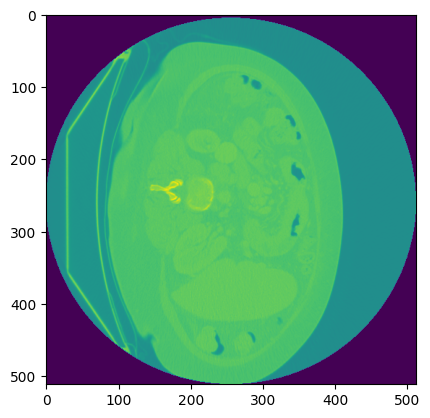

In [ ]:
train = train_load[:,:,47]
plt.imshow(train)
plt.show()

In [ ]:
test_load = nib.load('/content/content/data/Abdomen/RawData/Training/label/label0009.nii.gz').get_fdata()
test_load.shape

#Different patients have different number of slices

(512, 512, 149)

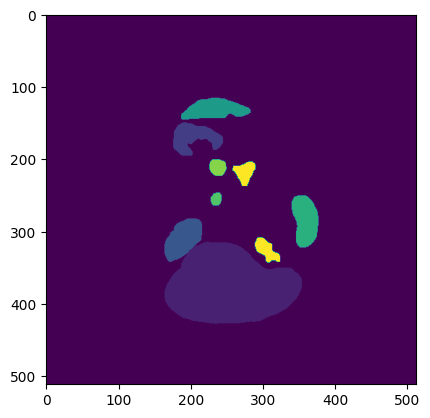

In [ ]:
test = test_load[:,:,59]
plt.imshow(test)
plt.show()

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
test[352]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
img_list

['/content/content/data/Abdomen/RawData/Training/img/img0030.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0008.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0026.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0029.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0028.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0038.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0004.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0005.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0039.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0010.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0033.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0002.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0034.nii.gz',
 '/content/content/data/Abdomen/RawData/Training/img/img0024.nii.gz',
 '/content/content/d

In [ ]:
class AbdomenDataset(Dataset):
  def __init__(self, img_list,lbl_list, input_D=5 , input_H= 256 , input_W=256, phase='train'):
    # with open(img_list, 'r') as f:
    #     self.img_list = [line.strip() for line in f]
    self.img_list= natsorted(img_list)
    self.lbl_list= natsorted(lbl_list)
    print("Processing {} datas".format(len(self.img_list)))
    # self.root_dir = root_dir
    self.input_D = input_D
    self.input_H = input_H
    self.input_W = input_W
    self.phase = "train"
    sample= {}

  def __nii2tensorarray__(self, data):
    [z, y, x] = data.shape
    new_data = np.reshape(data, [1, z, y, x])
    # print(new_data.shape,"new data")
    new_data = new_data.astype("float32")

    return new_data

  def __len__(self):
    return len(self.img_list)

  def __getitem__(self, idx):
    if self.phase == "train":
      # read image and label
      img_name = self.img_list[idx]
      label_name = self.lbl_list[idx]
      # print(img_name, label_name)
      # print(label_name, "i am here")
      assert os.path.isfile(img_name)
      assert os.path.isfile(label_name)
      img = nib.load(img_name)  # We have transposed the data from WHD format to DHW
      assert img is not None
      mask = nib.load(label_name)
      assert mask is not None

      # data processing
      img_array, mask_array = self.__training_data_process__(img, mask)

      # print(img_array.shape, mask_array.shape, "i am here2")
      # 2 tensor array
      img_array = self.__nii2tensorarray__(img_array)
      mask_array = self.__nii2tensorarray__(mask_array)

      assert img_array.shape ==  mask_array.shape, "img shape:{} is not equal to mask shape:{}".format(img_array.shape, mask_array.shape)

      sample = {'image': img_array, 'label': mask_array}

      return sample

    elif self.phase == "test":
      # read image
      # ith_info = self.img_list[idx].split(" ")
      # img_name = os.path.join(self.root_dir, ith_info[0])
      img_name= self.img_list[idx]
      # print(img_name)
      assert os.path.isfile(img_name)
      img = nib.load(img_name)

      assert img is not None

      # data processing
      img_array = self.__testing_data_process__(img)

      # 2 tensor array
      img_array = self.__nii2tensorarray__(img_array)

      return img_array


  def __drop_invalid_range__(self, volume, label=None):
      """
      Cut off the invalid area
      """
      zero_value = volume[0, 0, 0]
      non_zeros_idx = np.where(volume != zero_value)

      [max_z, max_h, max_w] = np.max(np.array(non_zeros_idx), axis=1)
      [min_z, min_h, min_w] = np.min(np.array(non_zeros_idx), axis=1)

      if label is not None:
          return volume[min_z:max_z, min_h:max_h, min_w:max_w], label[min_z:max_z, min_h:max_h, min_w:max_w]
      else:
          return volume[min_z:max_z, min_h:max_h, min_w:max_w]


  def __random_center_crop__(self, data, label):
      from random import random
      """
      Random crop
      """
      target_indexs = np.where(label>0)
      # print(target_indexs)
      [img_d, img_h, img_w] = data.shape
      [max_D, max_H, max_W] = np.max(np.array(target_indexs), axis=1)
      [min_D, min_H, min_W] = np.min(np.array(target_indexs), axis=1)
      [target_depth, target_height, target_width] = np.array([max_D, max_H, max_W]) - np.array([min_D, min_H, min_W])
      Z_min = int((min_D - target_depth*1.0/2) * random())
      Y_min = int((min_H - target_height*1.0/2) * random())
      X_min = int((min_W - target_width*1.0/2) * random())

      Z_max = int(img_d - ((img_d - (max_D + target_depth*1.0/2)) * random()))
      Y_max = int(img_h - ((img_h - (max_H + target_height*1.0/2)) * random()))
      X_max = int(img_w - ((img_w - (max_W + target_width*1.0/2)) * random()))

      Z_min = np.max([0, Z_min])
      Y_min = np.max([0, Y_min])
      X_min = np.max([0, X_min])

      Z_max = np.min([img_d, Z_max])
      Y_max = np.min([img_h, Y_max])
      X_max = np.min([img_w, X_max])

      Z_min = int(Z_min)
      Y_min = int(Y_min)
      X_min = int(X_min)

      Z_max = int(Z_max)
      Y_max = int(Y_max)
      X_max = int(X_max)

      return data[Z_min: Z_max, Y_min: Y_max, X_min: X_max], label[Z_min: Z_max, Y_min: Y_max, X_min: X_max]



  def __itensity_normalize_one_volume__(self, volume):
      """
      normalize the itensity of an nd volume based on the mean and std of nonzeor region
      inputs:
          volume: the input nd volume
      outputs:
          out: the normalized nd volume
      """

      pixels = volume[volume > 0]
      mean = pixels.mean()
      std  = pixels.std()
      out = (volume - mean)/std
      out_random = np.random.normal(0, 1, size = volume.shape)
      out[volume == 0] = out_random[volume == 0]
      return out

  def __resize_data__(self, data):
      """
      Resize the data to the input size
      """
      # print(data.shape)
      [depth, height, width] = data.shape
      # print(depth, height, width)
      scale = [self.input_D*1.0/depth, self.input_H*1.0/height, self.input_W*1.0/width]
      # data = ndimage.interpolation.zoom(data, scale, order=0)
      data = zoom(data, scale, order=0)

      return data


  def __crop_data__(self, data, label):
      """
      Random crop with different methods:
      """
      # random center crop
      data, label = self.__random_center_crop__ (data, label)

      return data, label

  def __training_data_process__(self, data, label):
      # crop data according net input size
      data = data.get_fdata()
      label = label.get_fdata()
      print(data.shape, label.shape)

      data= data.transpose(2, 1, 0)
      label= label.transpose(2, 1, 0)


      data= np.clip(data, a_min= -125, a_max= 275)

      # print(data.shape, label.shape, "Initially before IR ")
      # drop out the invalid range
      data, label = self.__drop_invalid_range__(data, label)

      # print(data.shape, label.shape, "After dropping invalid range ")
      # crop data
      # data, label = self.__crop_data__(data, label)

      # resize data
      data = self.__resize_data__(data)
      label = self.__resize_data__(label)

      # print(data.shape, label.shape, "After resizing ")

      # normalization datas
      data = self.__itensity_normalize_one_volume__(data)

      return data, label


  def __testing_data_process__(self, data):
      # crop data according net input size
      data = data.get_fdata()

      # resize data
      data = self.__resize_data__(data)

      # normalization datas
      data = self.__itensity_normalize_one_volume__(data)

      return data

In [ ]:
train_set = AbdomenDataset(img_list, mask_list, phase='train')

Processing 30 datas


In [ ]:
# train_set.__len__()
sample= train_set.__getitem__(0)
print(sample['label'].shape)

(512, 512, 147) (512, 512, 147)
(147, 512, 512) (147, 512, 512) Initially before IR 
(146, 429, 511) (146, 429, 511) After dropping invalid range 
(5, 256, 256) (5, 256, 256) After resizing 
(5, 256, 256) (5, 256, 256) i am here2
(1, 5, 256, 256)


In [ ]:

# trainloader = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=4, pin_memory=True,)

In [ ]:
# dataiter = iter(trainloader)
# sample= next(dataiter)
# print(sample['image'].shape)

In [ ]:
# class TrainDataset(Dataset):
#     def __init__(self, BASE_PATH, num_slices =4):
#         self.num_slices = num_slices
#         self.images = self.read_data(glob(BASE_PATH+"/img"+"/img*.gz", recursive= True))
#         self.masks = self.read_data(glob(BASE_PATH+"/label"+"/label*.gz", recursive= True), False)
#         assert len(self.images) == len(self.masks)

#     def read_data(self, paths, rescale = False, slc= 4):
#         # print(paths[0].shape)
#         data = np.concatenate([nib.load(path).get_fdata()[::slc, ::slc, :] for path in sorted(paths)], 2)
#         data= np.clip(data, a_min= -125, a_max= 275)

#         if rescale:
#           data = (data - data.min())/(data.max()-data.min()) * 255
#         # print(data.shape)
#         out= np.expand_dims(data, -1).astype('float32') / 255

#         out= np.transpose(out, (3, 2, 0, 1))
#         return out


#     def __len__(self):
#         return len(self.images)-self.num_slices

#     def __getitem__(self, idx):
#         # image = self.images[idx]
#         image = self.images[idx: idx + self.num_slices]
#         # print(image.shape)
#         mask = self.masks[idx: idx + self.num_slices]
#         return image, mask,

In [ ]:
# cfg_path= '/content/content/data/Abdomen/RawData/Training'
# ds= TrainDataset(cfg_path)

In [ ]:
sample =  train_set.__getitem__(0)
# sample= {'imidx': imidx, 'image': image, 'label': label}
print( sample['image'],sample['label'])

[[[[-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.6252894]
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]
   ...
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]]

  [[-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -1.7902424]
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]
   ...
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]
   [-2.758413  -2.758413  -2.758413  ... -2.758413  -2.758413
    -2.758413 ]]

  [[-2.758413  -2.758413  -2.758413  ... -2.75

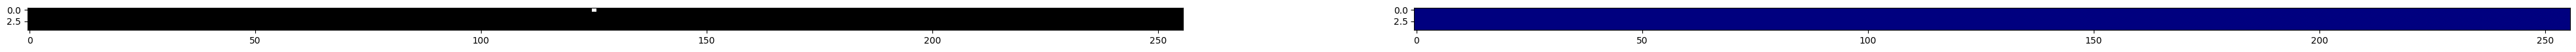

In [ ]:
idx= np.random.choice(len(train_set))
sample= train_set[idx]

viz.visualize( sample['image'],sample['label'])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv3d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm3d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='trilinear')

    return src


### RSU-6 ###
class RSU6(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=128, out_ch=14):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        # self.pool5 = nn.MaxPool3d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        # self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        # self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,mid_ch,dirate=1)

        self.side1 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side2 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side3 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side4 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side5 = nn.Conv3d(mid_ch,out_ch,3,padding=1)
        self.side6 = nn.Conv3d(mid_ch,out_ch,3,padding=1)

        self.outconv = nn.Conv3d(6*out_ch,out_ch,1)


    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)

        # hx7 = self.rebnconv7(hx6)

        # hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        # hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))


        # if test:
        #     return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)
        return d0, d1, d2, d3, d4, d5, d6


In [ ]:
net = RSU6(3,256, 14).cuda()

summary(net, input_size=(3, 64, 64, 64), batch_size= 1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [1, 14, 64, 64, 64]           1,148
       BatchNorm3d-2        [1, 14, 64, 64, 64]              28
              ReLU-3        [1, 14, 64, 64, 64]               0
          REBNCONV-4        [1, 14, 64, 64, 64]               0
            Conv3d-5       [1, 256, 64, 64, 64]          97,024
       BatchNorm3d-6       [1, 256, 64, 64, 64]             512
              ReLU-7       [1, 256, 64, 64, 64]               0
          REBNCONV-8       [1, 256, 64, 64, 64]               0
         MaxPool3d-9       [1, 256, 32, 32, 32]               0
           Conv3d-10       [1, 256, 32, 32, 32]       1,769,728
      BatchNorm3d-11       [1, 256, 32, 32, 32]             512
             ReLU-12       [1, 256, 32, 32, 32]               0
         REBNCONV-13       [1, 256, 32, 32, 32]               0
        MaxPool3d-14       [1, 256, 16,

In [ ]:
# class AugDataLoader(DataLoader):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.aug_data_gen = ImageDataGenerator(
#             rotation_range=15,
#             width_shift_range=0.15,
#             height_shift_range=0.15,
#             shear_range=0.1,
#             zoom_range=0.25,
#             fill_mode='nearest',
#             horizontal_flip=True,
#             vertical_flip=False
#         )

#     def aug_data(self, x, y):
#         xy = torch.cat([x, y], dim = 1).squeeze(dim = -1).permute(0, 2, 3, 1)
#         img_gen = self.aug_data_gen.flow(xy, shuffle=True, seed=42, batch_size = len(x))
#         # unblock
#         xy_scat = torch.tensor(next(img_gen)).permute(0, 3, 1, 2).unsqueeze(dim = 1)
#         return xy_scat[:, :, :xy_scat.shape[2]//2], xy_scat[:, :, xy_scat.shape[2]//2:]

#     def __iter__(self):
#         for data in super().__iter__():
#             data = self.aug_data(*data)
#             yield data

In [ ]:

training = 0
num_epoch = 10
batch_size = 16
num_folds = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
warnings.filterwarnings("ignore")

In [ ]:
print(train_set.__getitem__(0))

{'image': array([[[[-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.758413 , -2.6252894],
         [-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.758413 , -2.758413 ],
         [-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.758413 , -2.758413 ],
         ...,
         [-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.758413 , -2.758413 ],
         [-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.758413 , -2.758413 ],
         [-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.758413 , -2.758413 ]],

        [[-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.758413 , -1.7902424],
         [-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.758413 , -2.758413 ],
         [-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.758413 , -2.758413 ],
         ...,
         [-2.758413 , -2.758413 , -2.758413 , ..., -2.758413 ,
          -2.75

In [ ]:
# train_loaders = {}
# valid_loaders = {}
# train_folds= {}
# valid_folds= {}
# sss = StratifiedShuffleSplit(n_splits = num_folds, test_size = 0.2, random_state = 42)
# splitter = sss.split(train_set['images'][:len(ds)], train_set['images'][:len(ds)].sum(1).sum(1).sum(1).astype('int')%64)
# for fold, (train_indices, valid_indices) in enumerate(splitter):
#     train_folds[fold] = train_folds.get(fold, train_indices)
#     valid_folds[fold] = valid_folds.get(fold, valid_indices)
#     # Creating PT data samplers and loaders
#     train_sampler = SubsetRandomSampler(train_folds[fold])
#     valid_sampler = SubsetRandomSampler(valid_folds[fold])
#     # train_loaders[fold] = AugDataLoader(ds, batch_size = batch_size, sampler = train_sampler)
#     # valid_loaders[fold] = AugDataLoader(ds, batch_size = batch_size, sampler = valid_sampler)

In [ ]:
# print(len(ds))
# print(len(train_sampler))
# print(len(valid_sampler))

In [ ]:
# train_loaders = DataLoader(ds, batch_size = 10, sampler = train_sampler)
# dataiter = iter(train_loaders)
# sample, masks= next(dataiter)
# sample.shape

In [ ]:
def one_hot(labels: torch.Tensor, num_classes: int, dtype: torch.dtype = torch.float, dim: int = 1) -> torch.Tensor:
    """
    For every value v in `labels`, the value in the output will be either 1 or 0. Each vector along the `dim`-th
    dimension has the "one-hot" format, i.e., it has a total length of `num_classes`,
    with a one and `num_class-1` zeros.
    Note that this will include the background label, thus a binary mask should be treated as having two classes.

    Args:
        labels: input tensor of integers to be converted into the 'one-hot' format. Internally `labels` will be
            converted into integers `labels.long()`.
        num_classes: number of output channels, the corresponding length of `labels[dim]` will be converted to
            `num_classes` from `1`.
        dtype: the data type of the output one_hot label.
        dim: the dimension to be converted to `num_classes` channels from `1` channel, should be non-negative number.

    Example:

    For a tensor `labels` of dimensions [B]1[spatial_dims], return a tensor of dimensions `[B]N[spatial_dims]`
    when `num_classes=N` number of classes and `dim=1`.

    .. code-block:: python

        from monai.networks.utils import one_hot
        import torch

        a = torch.randint(0, 2, size=(1, 2, 2, 2))
        out = one_hot(a, num_classes=2, dim=0)
        print(out.shape)  # torch.Size([2, 2, 2, 2])

        a = torch.randint(0, 2, size=(2, 1, 2, 2, 2))
        out = one_hot(a, num_classes=2, dim=1)
        print(out.shape)  # torch.Size([2, 2, 2, 2, 2])

    """

    # if `dim` is bigger, add singleton dim at the end
    if labels.ndim < dim + 1:
        shape = list(labels.shape) + [1] * (dim + 1 - len(labels.shape))
        labels = torch.reshape(labels, shape)

    sh = list(labels.shape)

    if sh[dim] != 1:
        raise AssertionError("labels should have a channel with length equal to one.")

    sh[dim] = num_classes

    o = torch.zeros(size=sh, dtype=dtype, device=labels.device)
    labels = o.scatter_(dim=dim, index=labels.long(), value=1)

    return labels


In [ ]:
from torch.nn.modules.loss import _Loss

class DiceLoss(_Loss):

  def __init__(self,
              #  to_onehot_y: bool = False,
              #  sigmoid: bool = False,
                # softmax: bool = False,
               smooth_nr: float = 1e-5,
               smooth_dr: float = 1e-5,
               ):
    super().__init__()
    # self.to_onehot_y = to_onehot_y
    # self.sigmoid = sigmoid
    self.smooth_nr= smooth_nr
    self.smooth_dr= smooth_dr


    # self.softmax = softmax
  def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    # if self.sigmoid:
    input = torch.softmax(input, dim=1)
    n_pred_ch= input.shape[1]
    target = one_hot(target, num_classes=n_pred_ch)
    if target.shape != input.shape:
      raise AssertionError(f"ground truth has different shape ({target.shape}) from input ({input.shape})")
    # reducing, summing - only spatial dimensions (not batch nor channels)
    reduce_axis: list[int] = torch.arange(2, len(input.shape)).tolist()
    intersection = torch.sum(target * input, dim=reduce_axis)
    ground_o = torch.sum(target, dim=reduce_axis)
    pred_o = torch.sum(input, dim=reduce_axis)
    denominator = ground_o + pred_o
    f: torch.Tensor = 1.0 - (2.0 * intersection + self.smooth_nr) / (denominator + self.smooth_dr)
    num_of_classes = target.shape[1]
    f = torch.mean(f)
    return f



In [ ]:
# def softmax_helper(x):
#     # copy from: https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunet/utilities/nd_softmax.py
#     rpt = [1 for _ in range(len(x.size()))]
#     rpt[1] = x.size(1)
#     x_max = x.max(1, keepdim=True)[0].repeat(*rpt)
#     e_x = torch.exp(x - x_max)
#     return e_x / e_x.sum(1, keepdim=True).repeat(*rpt)

# def sum_tensor(inp, axes, keepdim=False):
#     # copy from: https://github.com/MIC-DKFZ/nnUNet/blob/master/nnunet/utilities/tensor_utilities.py
#     axes = np.unique(axes).astype(int)
#     if keepdim:
#         for ax in axes:
#             inp = inp.sum(int(ax), keepdim=True)
#     else:
#         for ax in sorted(axes, reverse=True):
#             inp = inp.sum(int(ax))
#     return inp

# def get_tp_fp_fn_tn(net_output, gt, axes=None, mask=None, square=False):
#     """
#     net_output must be (b, c, x, y(, z)))
#     gt must be a label map (shape (b, 1, x, y(, z)) OR shape (b, x, y(, z))) or one hot encoding (b, c, x, y(, z))
#     if mask is provided it must have shape (b, 1, x, y(, z)))
#     :param net_output:
#     :param gt:
#     :param axes: can be (, ) = no summation
#     :param mask: mask must be 1 for valid pixels and 0 for invalid pixels
#     :param square: if True then fp, tp and fn will be squared before summation
#     :return:
#     """
#     if axes is None:
#         axes = tuple(range(2, len(net_output.size())))

#     shp_x = net_output.shape
#     shp_y = gt.shape

#     with torch.no_grad():
#         if len(shp_x) != len(shp_y):
#             gt = gt.view((shp_y[0], 1, *shp_y[1:]))

#         if all([i == j for i, j in zip(net_output.shape, gt.shape)]):
#             # if this is the case then gt is probably already a one hot encoding
#             y_onehot = gt
#         else:
#             gt = gt.long()
#             y_onehot = torch.zeros(shp_x, device=net_output.device)
#             y_onehot.scatter_(1, gt, 1)

#     tp = net_output * y_onehot
#     fp = net_output * (1 - y_onehot)
#     fn = (1 - net_output) * y_onehot
#     tn = (1 - net_output) * (1 - y_onehot)

#     if mask is not None:
#         tp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tp, dim=1)), dim=1)
#         fp = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fp, dim=1)), dim=1)
#         fn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(fn, dim=1)), dim=1)
#         tn = torch.stack(tuple(x_i * mask[:, 0] for x_i in torch.unbind(tn, dim=1)), dim=1)

#     if square:
#         tp = tp ** 2
#         fp = fp ** 2
#         fn = fn ** 2
#         tn = tn ** 2

#     if len(axes) > 0:
#         tp = sum_tensor(tp, axes, keepdim=False)
#         fp = sum_tensor(fp, axes, keepdim=False)
#         fn = sum_tensor(fn, axes, keepdim=False)
#         tn = sum_tensor(tn, axes, keepdim=False)

#     return tp, fp, fn, tn



# # class SoftDiceLoss(nn.Module):
# #     def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.,
# #                  square=False):
# #         """
# #         paper: https://arxiv.org/pdf/1606.04797.pdf
# #         """
# #         super(SoftDiceLoss, self).__init__()

# #         self.square = square
# #         self.do_bg = do_bg
# #         self.batch_dice = batch_dice
# #         self.apply_nonlin = apply_nonlin
# #         self.smooth = smooth

# #     def forward(self, x, y, loss_mask=None):
# #         shp_x = x.shape

# #         if self.batch_dice:
# #             axes = [0] + list(range(2, len(shp_x)))
# #         else:
# #             axes = list(range(2, len(shp_x)))

# #         if self.apply_nonlin is not None:
# #             x = self.apply_nonlin(x)

# #         tp, fp, fn = get_tp_fp_fn(x, y, axes, loss_mask, self.square)

# #         dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)

# #         if not self.do_bg:
# #             if self.batch_dice:
# #                 dc = dc[1:]
# #             else:
# #                 dc = dc[:, 1:]
# #         dc = dc.mean()

# #         return -dc

# class GDL(nn.Module):
#     def __init__(self, apply_nonlin=None, batch_dice=False, do_bg=True, smooth=1.,
#                  square=False, square_volumes=False):
#         """
#         square_volumes will square the weight term. The paper recommends square_volumes=True; I don't (just an intuition)
#         """
#         super(GDL, self).__init__()

#         self.square_volumes = square_volumes
#         self.square = square
#         self.do_bg = do_bg
#         self.batch_dice = batch_dice
#         self.apply_nonlin = apply_nonlin
#         self.smooth = smooth

#     def forward(self, x, y, loss_mask=None):
#         shp_x = x.shape
#         shp_y = y.shape

#         if self.batch_dice:
#             axes = [0] + list(range(2, len(shp_x)))
#         else:
#             axes = list(range(2, len(shp_x)))

#         if len(shp_x) != len(shp_y):
#             y = y.view((shp_y[0], 1, *shp_y[1:]))

#         if all([i == j for i, j in zip(x.shape, y.shape)]):
#             # if this is the case then gt is probably already a one hot encoding
#             y_onehot = y
#         else:
#             gt = y.long()
#             y_onehot = torch.zeros(shp_x)
#             if x.device.type == "cuda":
#                 y_onehot = y_onehot.cuda(x.device.index)
#             y_onehot.scatter_(1, gt, 1)

#         if self.apply_nonlin is not None:
#             x = self.apply_nonlin(x)

#         if not self.do_bg:
#             x = x[:, 1:]
#             y_onehot = y_onehot[:, 1:]

#         tp, fp, fn, _ = get_tp_fp_fn_tn(x, y_onehot, axes, loss_mask, self.square)

#         # GDL weight computation, we use 1/V
#         volumes = sum_tensor(y_onehot, axes) + 1e-6 # add some eps to prevent div by zero

#         if self.square_volumes:
#             volumes = volumes ** 2

#         # apply weights
#         tp = tp / volumes
#         fp = fp / volumes
#         fn = fn / volumes

#         # sum over classes
#         if self.batch_dice:
#             axis = 0
#         else:
#             axis = 1

#         tp = tp.sum(axis, keepdim=False)
#         fp = fp.sum(axis, keepdim=False)
#         fn = fn.sum(axis, keepdim=False)

#         # compute dice
#         dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)

#         dc = dc.mean()

#         return 1-dc


In [ ]:
labels: {
        "0": "background",
        "1": "spleen",
        "2": "rkid",
        "3": "lkid",
        "4": "gall",
        "5": "eso",
        "6": "liver",
        "7": "sto",
        "8": "aorta",
        "9": "IVC",
        "10": "veins",
        "11": "pancreas",
        "12": "rad",
        "13": "lad"
    }



In [ ]:
# fold = np.random.choice(list(train_loaders))
# print(fold)
# images, mask = next(iter(train_loaders[fold]))
# print(images.shape)

In [ ]:
# class BCEDiceLoss(nn.Module):
#   def __init__(self):
#     super().__init__()

#   def forward(self, input, target):
#     bce = F.binary_cross_entropy_with_logits(input, target)
#     smooth = 1e-5
#     input = torch.sigmoid(input)
#     # input = torch.tanh(input)
#     num = target.size(0)
#     input = input.contiguous().view(num, -1)
#     target = target.contiguous().view(num, -1)
#     intersection = (input * target)
#     dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
#     dice = 1 - dice.sum() / num
#     return 0.5 * bce + dice


class AbdomenNetLoss(nn.Module):
  def __init__(self):
    super(AbdomenNetLoss, self).__init__()
    # self.apply_nonlin = softmax_helper
    # self.batch_dice= True
    self.loss = DiceLoss()
    # self.loss= GDL(apply_nonlin=self.apply_nonlin, batch_dice=self.batch_dice, smooth=1e-5, do_bg=False)

  def forward(self, d0, d1, d2, d3, d4, d5, d6, labels_v):
    loss0 = self.loss(d0, labels_v)
    loss1 = self.loss(d1, labels_v)
    loss2 = self.loss(d2, labels_v)
    loss3 = self.loss(d3, labels_v)
    loss4 = self.loss(d4, labels_v)
    loss5 = self.loss(d5, labels_v)
    loss6 = self.loss(d6, labels_v)
    loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
    print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n" % (
        loss0.data, loss1.data, loss2.data, loss3.data, loss4.data, loss5.data, loss6.data,))
    return loss0, loss

In [ ]:
kwargs= {
    'name' : 'AbdomenNet',
    'fold': 0,
    'epochs' : 20,
    'batch_size': 2,
    # 'input_channels': 1,
    # 'num_classes' : 1,
    # 'input_size': 64,
    'data_folder_name': 'train_data',
    'optimizer': 'Adam',
    'lr': 0.001,
    'nesterov': False,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'scheduler': 'CosineAnnealingLR',
    'min_lr': 1e-7,
    'factor': 0.1,
    'patience': 3,
    'milestones': '1,2',
    'gamma' : 2/3,
    'early_stopping' : 1,
    'num_workers':4
}

In [ ]:
class Model_Train():
  def __init__(self, train_set ,**kwargs):
      self.model_loss = AbdomenNetLoss()
      self.model_name = kwargs['name']
      self.epoch_num = kwargs['epochs']
      self.save_frq = 1100  # save the model every 1000 iterations
      self.batch_size_train = kwargs['batch_size']
      self.epoch = 0
      self.model_dir= '/content/drive/MyDrive/Colab Notebooks/MEDAI_MAR/'

      self.root_dir = "/content/"
      self.log_dir = os.path.join(self.root_dir, "logs/my_board/" + os.sep)
      self.pthFile_name = "NONE"
      self.writer = SummaryWriter(self.log_dir)
      self.train_set= train_set

      print("---")
      print("train images: ", len(self.train_set))
      print("train labels: ", len(self.train_set))
      print("---")
      self.train_num = len(train_set)


      # ------- 2. set the directory of training dataset --------
      # data_dir = os.path.join(self.root_dir, config['data_folder_name'] + os.sep)
      # tra_image_dir = os.path.join("images" + os.sep)
      # tra_label_dir = os.path.join("labels" + os.sep)
      # image_ext = ".jpg"
      # label_ext = ".bmp"
      # self.model_dir = os.path.join(self.root_dir, config['data_folder_name'], self.model_name + os.sep)
      # os.makedirs(self.model_dir, exist_ok=True)
      # tra_img_name_list = glob.glob(data_dir + tra_image_dir + "*" + image_ext)

      # tra_lbl_name_list = []
      # for img_path in tra_img_name_list:
      #     img_name = img_path.split(os.sep)[-1]
      #     aaa = img_name.split(".")
      #     bbb = aaa[0:-1]
      #     imidx = bbb[0]
      #     for i in range(1, len(bbb)):
      #         imidx = imidx + "." + bbb[i]
      #     tra_lbl_name_list.append(data_dir + tra_label_dir + imidx + label_ext)

      # print("---")
      # print("train images: ", len(self.train_set))
      # print("train labels: ", len(self.train_set))
      # print("---")
      # self.train_num = len(train_set)
      # glioma_dataloader = Glioma_dataloader(img_name_list=tra_img_name_list, lbl_name_list=tra_lbl_name_list,
      #                                       transform= train_transforms)

                                      # transform=transforms.Compose([RescaleT(kwargs['input_size']), ToTensorLab(flag=0)]), )
      # train_loaders[kwargs['fold']] = AugDataLoader(ds, batch_size = self.batch_size_train, sampler = self.train_sampler)
      # train_loaders[kwargs['fold']] = DataLoader(train_set, batch_size=10, shuffle=True, num_workers=4, pin_memory=True,)
      self.abdomen_dataloader = DataLoader(self.train_set, batch_size=kwargs['batch_size'], shuffle=True, num_workers=4, pin_memory=True,)
      self.model = RSU6(in_ch = 3, mid_ch= 256, out_ch= 14).cuda()
      # self.model= DexiNed().cuda()
      # self.train_num = len(self.abdomen_dataloader)



      params = filter(lambda p: p.requires_grad, self.model.parameters())
      if kwargs['optimizer'] == 'Adam':
        self.optimizer = optim.Adam(params, lr=kwargs['lr'], betas=(0.9, 0.999), eps=1e-08,weight_decay=0, ) #weight_decay=config['weight_decay'])
      elif kwargs['optimizer'] == 'SGD':
        self.optimizer = optim.SGD(params, lr=kwargs['lr'], momentum=kwargs['momentum'], nesterov=kwargs['nesterov'],weight_decay=kwargs['weight_decay'])
      else:
        raise NotImplementedError

      if kwargs['scheduler'] == 'CosineAnnealingLR':
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=kwargs['epochs'], eta_min=kwargs['min_lr'])
      elif kwargs['scheduler'] == 'ReduceLROnPlateau':
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, factor=kwargs['factor'], patience=kwargs['patience'],
                                                      verbose=1, min_lr=kwargs['min_lr'])
      elif kwargs['scheduler'] == 'MultiStepLR':
        self.scheduler = lr_scheduler.MultiStepLR(self.optimizer,
                                                milestones=[int(e) for e in kwargs['milestones'].split(',')],
                                                gamma=kwargs['gamma'])
      elif kwargs['scheduler'] == 'ConstantLR':
        self.scheduler = None
      else:
        raise NotImplementedError
  def model_train(self):
    if self.pthFile_name != "NONE":
      checkpoint = torch.load(self.pthFile_name)
      print("Pretrained Model - Started for training")
      if checkpoint["epoch"] > 0:
        self.model.load_state_dict(checkpoint["model_state_dict"])
        epoch = checkpoint["epoch"]
        print(f"=====> epoch:{epoch}")
        if torch.cuda.is_available():
          self.model.cuda()
          # ------- 4. define optimizer --------
        print("---define optimizer on retraining...")
        # self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
      else:
        if torch.cuda.is_available():
            self.model.cuda()
        # ------- 4. define optimizer --------
        print("---define optimizer...")
        #self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )
    else:
      if torch.cuda.is_available():
        self.model.cuda()
      # ------- 4. define optimizer --------
      print("---define optimizer...")
      # self.optimizer = optim.Adam(self.model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, )

      # ------- 5. training process --------
    print("---start training...")
    ite_num = 0
    running_loss = 0.0
    running_tar_loss = 0.0
    ite_num4val = 0
    while self.epoch < self.epoch_num:
      self.model.train()
      for i, data in enumerate(self.abdomen_dataloader):
        print(i)
        ite_num = ite_num + 1
        ite_num4val = ite_num4val + 1


        inputs, labels = data['image'], data['label']
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        B,C,D,H, W, = inputs.shape
        inputs = inputs.expand(B,3, D,H, W)


        # wrap them in Variable
        if torch.cuda.is_available():
          inputs_v, labels_v = (
          Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(), requires_grad=False),)
        else:
          inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

        # y zero the parameter gradients
        self.optimizer.zero_grad()
        # forward + backward + optimize
        d0, d1, d2, d3, d4, d5, d6 = self.model(inputs_v)
        # loss= self.model_loss(d0, labels_v)
        loss2, loss = self.model_loss(d0, d1, d2, d3, d4, d5, d6, labels_v)
        loss.backward()
        self.optimizer.step()
        # # print statistics
        running_loss += loss.data
        running_tar_loss += loss2.data
        # del temporary outputs and loss
        del d0, d1, d2, d3, d4, d5, d6, loss
        print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
            # self.epoch + 1, self.epoch_num, self.epoch*self.batch_size_train, self.epoch_num*self.batch_size_train, ite_num,
            self.epoch + 1, self.epoch_num, (i + 1) * self.batch_size_train, self.train_num, ite_num,
            running_loss / ite_num4val,
            running_tar_loss / ite_num4val,
            ))

        self.writer.add_scalar("train loss", running_loss / ite_num4val, self.epoch + 1)
        self.writer.add_scalar("tar loss", running_tar_loss / ite_num4val)

        if ite_num % self.save_frq == 0:
          torch.save({"epoch": self.epoch, "model_state_dict": self.model.state_dict(),
                      "optimizer_state_dict": self.optimizer.state_dict(), },
                      self.model_dir + self.model_name + "_%d_at2_Unet3d_bce_itr_%d_train_%3f_tar_%3f.pth" % (
                      self.epoch, ite_num, running_loss / ite_num4val,
                      running_tar_loss / ite_num4val,
                      ), )
          running_loss = 0.0
          running_tar_loss = 0.0
          self.model.train()  # resume train
          ite_num4val = 0

      self.epoch = self.epoch + 1
      self.scheduler.step()
      print(f"Current Learning Rate:{self.optimizer.param_groups[0]['lr']} ")

    torch.save(
        {"epoch": self.epoch, "model_state_dict": self.model.state_dict(),
          "optimizer_state_dict": self.optimizer.state_dict(), },
        self.model_dir + self.model_name + "_%d_at2_final_Unet3d_bce_itr_%d_train_%3f_tar_%3f.pth" % (
        self.epoch, ite_num, running_loss / ite_num4val,
        running_tar_loss / ite_num4val,
        ), )


In [ ]:
model_obj = Model_Train(train_set, **kwargs)
model_obj.model_train()

---
train images:  30
train labels:  30
---
---define optimizer...
---start training...
0
l0: 0.984703, l1: 0.985847, l2: 0.983138, l3: 0.984985, l4: 0.985334, l5: 0.983535, l6: 0.986520

[epoch:   1/ 20, batch:     2/   30, ite: 1] train loss: 6.894062, tar: 0.984703 
1
l0: 0.961654, l1: 0.930063, l2: 0.936839, l3: 0.939989, l4: 0.959445, l5: 0.956706, l6: 0.969498

[epoch:   1/ 20, batch:     4/   30, ite: 2] train loss: 6.774127, tar: 0.973178 
2
l0: 0.941312, l1: 0.925094, l2: 0.924311, l3: 0.924485, l4: 0.941180, l5: 0.937411, l6: 0.947705

[epoch:   1/ 20, batch:     6/   30, ite: 3] train loss: 6.696584, tar: 0.962556 
3
l0: 0.898365, l1: 0.895934, l2: 0.916022, l3: 0.907359, l4: 0.924943, l5: 0.923316, l6: 0.926352

[epoch:   1/ 20, batch:     8/   30, ite: 4] train loss: 6.620511, tar: 0.946508 
4
l0: 0.894075, l1: 0.892836, l2: 0.914806, l3: 0.912634, l4: 0.922566, l5: 0.924352, l6: 0.926166

[epoch:   1/ 20, batch:    10/   30, ite: 5] train loss: 6.573895, tar: 0.936022 
5


In [ ]:
path_= '/content/drive/MyDrive/Colab Notebooks/MEDAI_MAR/AbdomenNet_20_at2_final_Unet3d_bce_itr_300_train_5.221040_tar_0.613497.pth'

sample_model =RSU6(3, 256, 14).cuda()

checkpoint = torch.load(path_)

sample_model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.Adam(sample_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,weight_decay=0, )

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print("Model loaded!")

<All keys matched successfully>

Model loaded!


In [ ]:
# cfg_path= '/content/content/data/Abdomen/RawData/Testing'

# img_list_test= glob(cfg_path+"/img"+"/img*.gz", recursive= True)

In [ ]:
# img_list_test

In [ ]:
sample_set = AbdomenDataset(img_list, mask_list, input_D=5 , input_H= 256 , input_W=256,phase='train')

Processing 30 datas


In [ ]:
sample_loader = DataLoader(sample_set, batch_size=1, shuffle=True, num_workers=1, pin_memory=False)

In [ ]:
swargs= {
    'model_name': 'Abdomenet',
    'test_save_dir': '/content/data/preds',
    'output_dir': '/content/data/preds',

}

In [ ]:
def test(data_loader, model, img_list, mask_list, test_save_path, z_spacing= 1):
    masks = []
    model.eval() # for testing
    for batch_id, batch_data in enumerate(data_loader):
        # forward
        volume, labels = batch_data['image'], batch_data['label']
        volume, labels = volume.cuda(), labels.cuda()

        input= volume

        B,C,D,H, W, = input.shape
        input = input.expand(B,3, D,H, W)


        with torch.no_grad():
            probs, _,_, _, _,_, _  = model(input)
            # print(probs.shape, "prediction")
            probs = F.softmax(probs, dim=1)

            probs= probs.cpu().detach().numpy()

        # resize mask to original size
        [batchsize, _, mask_d, mask_h, mask_w] = probs.shape
        [depth, height, width] = input.size()[2:]
        mask = probs[0]
        # print(mask.shape, "Mask")
        scale = [1, depth*1.0/mask_d, height*1.0/mask_h, width*1.0/mask_w]
        mask = zoom(mask, scale, order=1)
        mask = np.argmax(mask, axis=0)

        swargs['test_save_dir'] = os.path.join(swargs['output_dir'], swargs['model_name'])
        test_save_path = swargs['test_save_dir']
        os.makedirs(test_save_path, exist_ok=True)
        # print(test_save_path)



        image, label = volume[0].squeeze(0).cpu().detach().numpy(), labels[0].squeeze(0).cpu().detach().numpy()
        # print(image.shape, label.shape, mask.shape, "ILP")
        img_itk = sitk.GetImageFromArray(image.astype(np.float32))
        prd_itk = sitk.GetImageFromArray(mask.astype(np.float32))
        lab_itk = sitk.GetImageFromArray(label.astype(np.float32))
        img_itk.SetSpacing((1, 1, z_spacing))
        prd_itk.SetSpacing((1, 1, z_spacing))
        lab_itk.SetSpacing((1, 1, z_spacing))
        sitk.WriteImage(prd_itk, test_save_path + '/' + "_pred.nii.gz")
        sitk.WriteImage(img_itk, test_save_path + '/' + "_img.nii.gz")
        sitk.WriteImage(lab_itk, test_save_path + '/' + "_gt.nii.gz")
        # # mask = np.argmax(mask, axis=1)

    #     masks.append(mask)

    # return masks


In [ ]:
test_save_path=  '/content/data/preds'
test(sample_loader, sample_model, img_list= img_list, mask_list= mask_list, test_save_path=None)

In [ ]:
idx= 3

train_load = nib.load('/content/data/preds/Abdomenet/_img.nii.gz').get_fdata()
train_load.shape

(256, 256, 5)

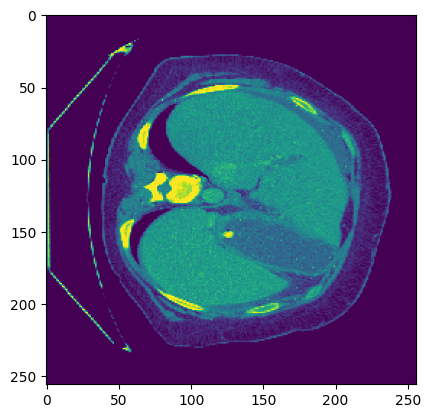

In [ ]:
train = train_load[:,:,idx]
plt.imshow(train)
plt.show()

In [ ]:
train_load = nib.load('/content/data/preds/Abdomenet/_gt.nii.gz').get_fdata()
train_load.shape

(256, 256, 5)

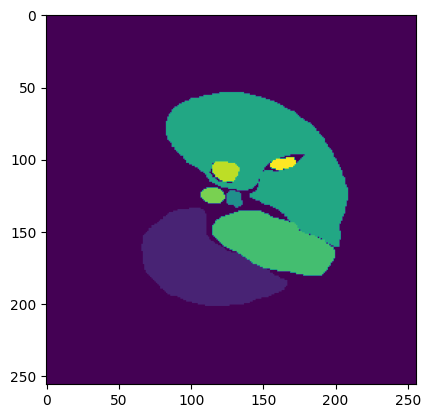

In [ ]:
train = train_load[:,:,idx]
plt.imshow(train)
plt.show()

In [ ]:
train_load = nib.load('/content/data/preds/Abdomenet/_pred.nii.gz').get_fdata()
train_load.shape

(256, 256, 5)

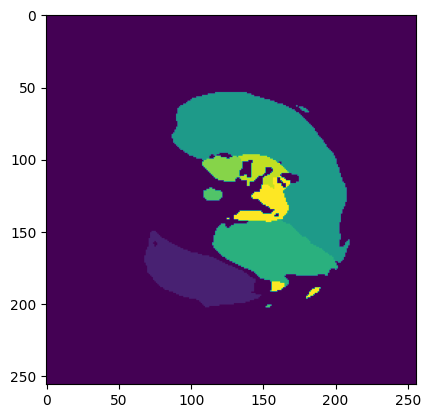

In [ ]:
train = train_load[:,:,idx]
plt.imshow(train)
plt.show()

<Axes: >

(-0.5, 333.5, 333.5, -0.5)

Text(0.5, 1.0, 'CT')

<Axes: >

(-0.5, 334.5, 335.5, -0.5)

Text(0.5, 1.0, 'GT')

<Axes: >

(-0.5, 337.5, 334.5, -0.5)

Text(0.5, 1.0, 'Prediction')

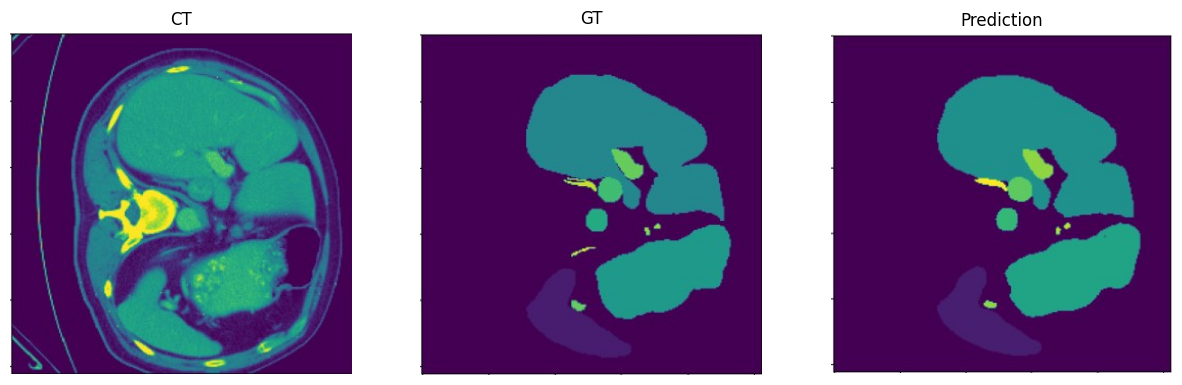

In [ ]:
# code for displaying multiple images in one figure

#import libraries
import cv2
from matplotlib import pyplot as plt

# create figure
fig = plt.figure(figsize=(15, 10))

# setting values to rows and column variables
rows = 1
columns = 3

# reading images
Image1 = cv2.imread('/content/CT_02.jpg', cv2.IMREAD_UNCHANGED)
Image1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2RGB)
Image2 = cv2.imread('/content/gt_02.jpg', cv2.IMREAD_UNCHANGED)
Image2 = cv2.cvtColor(Image2, cv2.COLOR_BGR2RGB)
Image3 = cv2.imread('/content/pred_02.jpg', cv2.IMREAD_UNCHANGED)
Image3 = cv2.cvtColor(Image3, cv2.COLOR_BGR2RGB)
# Image4 = cv2.imread('Image4.jpg')

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1, cmap= 'bone')
plt.axis('off')
plt.title("CT")

# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2, cmap= 'jet')
plt.axis('off')
plt.title("GT")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Prediction")
